<a href="https://colab.research.google.com/github/varJATIN/Ocular-fundus-image-Analysis/blob/main/late_fusion_densenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import sys
import random
import IPython

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from matplotlib.pyplot import imread

import tensorflow as tf
from tensorflow import keras

from sklearn.utils import shuffle
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix,confusion_matrix

from matplotlib.pyplot import imread
from cv2 import resize

from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Dropout
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from sklearn.preprocessing import OneHotEncoder

from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow

random.seed = 2
#np.random.seed = 2
tf.seed = 2
tf.random.set_seed(2)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Read, Split train_val & oversample train set


In [3]:
dataset_images_location = "/content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/a. Training Set"
dataset_groundtruth_location = "/content/drive/MyDrive/IDRid/B. Disease Grading/2. Groundtruths/a. IDRiD_Disease Grading_Training Labels.csv"

df = pd.read_csv(dataset_groundtruth_location)
df_ = pd.DataFrame();
df_['Image name'] = df['Image name']

df_['Retinopathy grade'] = df['Retinopathy grade']

train_df, val_df = train_test_split(df_, test_size = 0.15, random_state = 25);
train_df.head()

,Image name,Retinopathy grade
72,IDRiD_073,2
256,IDRiD_257,0
290,IDRiD_291,1
311,IDRiD_312,0
389,IDRiD_390,4


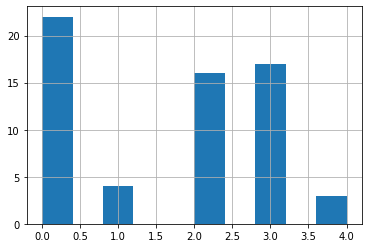

In [4]:
val_df['Retinopathy grade'].hist()

In [5]:
def balance_data(class_size, df):
    train_df = df.groupby(['Retinopathy grade']).apply(lambda x: x.sample(class_size, replace = True)).reset_index(drop = True)
    train_df = train_df.sample(frac=1).reset_index(drop=True)
    print('New Data Size:', train_df.shape[0], 'Old Size:', df.shape[0])
    train_df['Retinopathy grade'].hist(figsize = (10, 5))
    return train_df

New Data Size: 600 Old Size: 351


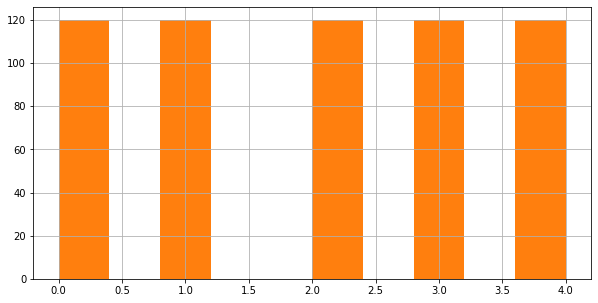

In [6]:
train_df = balance_data(train_df.pivot_table(index='Retinopathy grade', aggfunc=len).max().max(),train_df) # I will oversample such that all classes have the same number of images as the maximum
train_df['Retinopathy grade'].hist(figsize = (10, 5))

In [7]:
image_names = train_df['Image name'];
im_size = 512;

train_labels = [];
for label in train_df['Retinopathy grade']:
    for i in range(2): # 2 times for data augmentation
      train_labels.append(label)

print("len of labels ",len(train_labels))

train_images= np.zeros((2*len(train_df['Image name']),im_size,im_size,3))

index=0
for image_name in image_names:
    #read image
    img = imread(dataset_images_location + '/' + image_name + ".jpg");
    img = cv2.resize(img, (im_size, im_size));
    #load into array
    train_images[index,:,:,0:3] = img

    #rot 180
    train_images[index + 1] = np.rot90(np.rot90(img))
    
    index = index + 2

train_images = train_images.astype('float32') / np.max(train_images)
train_labels = np.array(train_labels, ndmin = 2)
train_labels = np.transpose(train_labels)

enc = OneHotEncoder(categories='auto', drop=None, sparse=False, dtype = np.int, handle_unknown='error')
enc.fit(train_labels)
train_labels = enc.transform(train_labels)

print(train_images.shape)
print(train_labels.shape) 
train_labels[0:5]

len of labels  1200
(1200, 512, 512, 3)
(1200, 5)


array([[0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0]])

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    shear_range=0.0,
    zoom_range=[0.75,1],
    #brightness_range=[0.,0.01],
    #zca_whitening	=True,
    width_shift_range=1.1,
    height_shift_range=0.05,
    rotation_range=15,
    fill_mode='nearest',
    horizontal_flip=True,
    vertical_flip=True)
train_datagen.fit(train_images)

## Read test_df


In [19]:
test_images_location = "/content/drive/My Drive/IDRid/B. Disease Grading/1. Original Images/b. Testing Set"
test_groundtruth_location = "/content/drive/MyDrive/IDRid/B. Disease Grading/2. Groundtruths/b. IDRiD_Disease Grading_Testing Labels.csv"

test_df = pd.read_csv(test_groundtruth_location)
test_df_ = pd.DataFrame();
test_df_['Image name'] = test_df['Image name']
test_df_['Retinopathy grade'] = test_df['Retinopathy grade']
test_df = test_df_
print(test_df.head())

  Image name  Retinopathy grade
0  IDRiD_001                  4
1  IDRiD_002                  4
2  IDRiD_003                  4
3  IDRiD_004                  4
4  IDRiD_005                  4


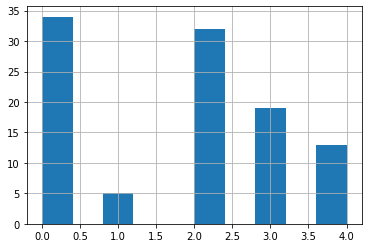

In [20]:
test_df['Retinopathy grade'].hist()

In [21]:
test_image_names = [];
test_image_names = test_df['Image name'];
print("len of test set ",len(test_image_names))
im_size = 512;

test_labels = [];
test_labels = test_df['Retinopathy grade'];

test_images = []
for image_name in test_image_names:
    img = cv2.imread(test_images_location + '/' + image_name + ".jpg");
    img = cv2.resize(img, (im_size, im_size));
    test_images.append(img);

test_images = np.array(test_images)
test_images = test_images.astype('float32') / np.max(test_images)
test_labels = np.array(test_labels, ndmin = 2)
test_labels = np.transpose(test_labels)

test_labels = enc.transform(test_labels)

print(test_images.shape)
print(test_labels.shape) 

len of test set  103
(103, 512, 512, 3)
(103, 5)


In [9]:
val_image_names = [];
val_image_names = val_df['Image name'];
print("len of val set ",len(val_image_names))
im_size = 512;

val_labels = [];
val_labels = val_df['Retinopathy grade'];

val_images = []
for image_name in val_image_names:
    img = cv2.imread(dataset_images_location + '/' + image_name + ".jpg");
    img = cv2.resize(img, (im_size, im_size));
    val_images.append(img);

val_images = np.array(val_images)
val_images = val_images.astype('float32') / np.max(val_images)
val_labels = np.array(val_labels, ndmin = 2)
val_labels = np.transpose(val_labels)

#use encoder fitted on train data for both val and test data
val_labels = enc.transform(val_labels)

print(val_images.shape)
print(val_labels.shape) 

len of val set  62
(62, 512, 512, 3)
(62, 5)


In [10]:
val_datagen = ImageDataGenerator(
    shear_range=0.0,
    zoom_range=[0.75,1],
    width_shift_range=1.1,
    height_shift_range=0.05,
    rotation_range=15,
    fill_mode='nearest',
    horizontal_flip=True,
    vertical_flip=True)
val_datagen.fit(val_images)

In [ ]:
from sklearn.utils import shuffle
train_images, train_labels = shuffle(train_images, train_labels, random_state = 1)
# If train and test are from respective sets
print("train x size ",train_images.shape)
print("train y size ",train_labels.shape)
print("test x size ",test_images.shape)
print("test y size ",test_labels.shape)
print("val x size ",val_images.shape)
print("val y size ",val_labels.shape)

train x size  (1200, 512, 512, 3)
train y size  (1200, 5)
test x size  (103, 512, 512, 3)
test y size  (103, 5)
val x size  (42, 512, 512, 3)
val y size  (42, 5)


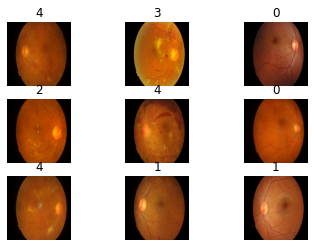

In [13]:
for i in range(9):
  ax=plt.subplot(3,3,i+1)
  plt.imshow(train_images[2*i+1])
  plt.title("{}".format(np.argmax(train_labels[2*i+1]))) 
  plt.axis('off')

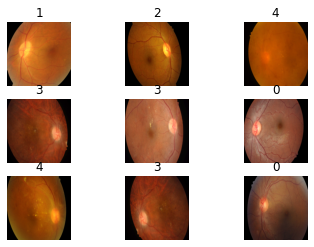

In [29]:
x=train_datagen.flow(train_images, train_labels,batch_size=9,shuffle=True)
for i,(img,lbl) in enumerate(x):
  for j in range(9):
    ax=plt.subplot(3,3,j+1)  
    plt.imshow(img[j])
    plt.title("{}".format(np.argmax(lbl[j]))) 
    plt.axis('off')
  break
del x

In [11]:
from keras.models import Sequential
from tensorflow.keras.applications.densenet import DenseNet121#,Resnet50
from keras.models import Model

## Load Segmentation model 


In [12]:
from tensorflow.keras.models import model_from_json

def load_seg_model(model_name):
    """
    loads the pretrained seg model of given lesion
    """
    # # load json and create model
    json_file = open('/content/drive/MyDrive/IDRid/{}.json'.format(model_name), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)

    # # load weights into new model
    loaded_model.load_weights("/content/drive/MyDrive/IDRid/{}.h5".format(model_name))
    # print("Loaded model from disk")

    # # evaluate loaded model on test data
    loaded_model.compile()
    print(model_name," Model loaded and compiled")
    return loaded_model

In [13]:
def build_model(num_classes):
    random.seed = 1337
    tf.seed = 1337
    tf.random.set_seed(1337)
    
    IMG_SIZE=224
    NUM_CLASSES=num_classes
    # define inputs
    input_0 =layers.Input(shape=(512,512, 3))
    input_1=tf.keras.layers.experimental.preprocessing.Resizing(IMG_SIZE,IMG_SIZE,  name='resize_densenet')(input_0)
    #input_0_ma  =tf.keras.layers.experimental.preprocessing.Resizing(640,640,  name='resize_ma')(input_0)
    #input_1 = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    
    #input_ex=layers.Input(shape=(512,512,1))
    #input_se=layers.Input(shape=(512,512,1))
    #input_ma=layers.Input(shape=(640,640,1))
    
    base_model = DenseNet121(include_top=False, input_tensor=input_1, weights="imagenet")
    ex_model=load_seg_model("model_EX")
    ma_model=load_seg_model("model_MA")
    se_model=load_seg_model("model_SE")
    he_model=load_seg_model("model_HE")
    # Freeze the pretrained weights
    base_model.trainable = False
    ex_model.trainable=False
    se_model.trainable=False
    ma_model.trainable=False
    he_model.trainable=False
    ex_model._name='model_ex'
    ma_model._name='model_ma'
    se_model._name='model_se'
    he_model._name='model_he'
    for layer in he_model.layers:
      layer._name = layer.name + '_he'
    for layer in se_model.layers:
      layer._name = layer.name + '_se'
    for layer in ex_model.layers:
      layer._name = layer.name + '_ex'
    for layer in ma_model.layers:
      layer._name = layer.name + '_ma'
    #pass image for lesion
    les_ex=ex_model(input_0)
    les_se=se_model(input_0)
    les_ma=ma_model(input_0)
    les_he=he_model(input_0)
    #les_ma=tf.keras.layers.experimental.preprocessing.Resizing(640,640,  name='resize_ma')(les_ma)
    lesions=layers.Concatenate()([input_0,les_ex,les_se,les_ma,les_he])
    #block1
    f_lesions=Conv2D(16,3,strides=(1,1),padding='same')(lesions)
    f_lesions=layers.BatchNormalization(name='1_bn')(f_lesions)
    f_lesions=layers.Activation('relu')(f_lesions)
    f_lesions=MaxPooling2D()(f_lesions)
    #block2
    f_lesions=Conv2D(32,3,strides=(1,1),padding='same')(f_lesions)
    f_lesions=layers.BatchNormalization(name='2_bn')(f_lesions)
    f_lesions=layers.Activation('relu')(f_lesions)
    f_lesions=MaxPooling2D()(f_lesions)
    #block3
    f_lesions=Conv2D(64,3,strides=(1,1),padding='same')(f_lesions)
    f_lesions=layers.BatchNormalization(name='3_bn')(f_lesions)
    f_lesions=layers.Activation('relu')(f_lesions)
    f_lesions=MaxPooling2D()(f_lesions)
    #block4
    f_lesions=Conv2D(64,3,strides=(1,1),padding='same')(f_lesions)
    f_lesions=layers.BatchNormalization(name='5_bn')(f_lesions)
    f_lesions=layers.Activation('relu')(f_lesions)
    f_lesions=MaxPooling2D()(f_lesions)
    #block5
    f_lesions=Conv2D(64,3,strides=(1,1),padding='same')(f_lesions)
    f_lesions=layers.BatchNormalization(name='6_bn')(f_lesions)
    f_lesions=layers.Activation('relu',)(f_lesions)
    f_lesions=MaxPooling2D()(f_lesions)
    #block6
    f_lesions=Conv2D(64,3,strides=(1,1),padding='valid')(f_lesions)
    f_lesions=layers.BatchNormalization(name='7_bn')(f_lesions)
    f_lesions=layers.Activation('relu')(f_lesions)
    f_lesions=MaxPooling2D()(f_lesions)
    
    #f_lesions=layers.GlobalMaxPooling2D()(f_lesions)
    #print(f_lesions.shape)
    #x=layers.GlobalMaxPooling2D()(model.output)
    x=layers.Concatenate()([base_model.output,f_lesions])
    # Rebuild top
    x = Flatten(name="flatten")(x)
    
    top_dropout_rate = 0.2
    x = Dropout(top_dropout_rate, name="top_dropout_1")(x)
    x = Dense(256, activation="relu", name="last_dense_1")(x)
    x = Dropout(top_dropout_rate, name="top_dropout_2")(x)
    x = Dense(256, activation="relu", name="last_dense_2")(x)
    outputs = Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(input_0, outputs, name="Segnet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4,beta_1=0.9)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [14]:
random.seed = 1337
tf.seed = 1337
tf.random.set_seed(1337)
model=build_model(5)

29089792/29084464 [==============================] - 0s 0us/step
model_EX  Model loaded and compiled
model_MA  Model loaded and compiled
model_SE  Model loaded and compiled
model_HE  Model loaded and compiled


In [ ]:
from keras.utils.layer_utils import count_params
trainable_count = count_params(model.trainable_weights)
non_trainable_count = count_params(model.non_trainable_weights)

print('Total params: {:,}'.format(trainable_count + non_trainable_count))
print('Trainable params: {:,}'.format(trainable_count))
print('Non-trainable params: {:,}'.format(non_trainable_count))

In [ ]:
plot_model(
    model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

In [15]:
random.seed = 1337
tf.seed = 1337
tf.random.set_seed(1337)
early_stopping= tf.keras.callbacks.EarlyStopping(monitor = 'accuracy', min_delta = 0.01, patience = 6)
hist=model.fit(train_datagen.flow(train_images, train_labels,batch_size=6,shuffle=True),steps_per_epoch=len(train_images) / 6,
               epochs = 50, callbacks = [early_stopping],validation_data=val_datagen.flow(val_images,val_labels,batch_size=6));

Epoch 1/50
200/200 [==============================] - 173s 596ms/step - loss: 2.0144 - accuracy: 0.3820 - val_loss: 1.7363 - val_accuracy: 0.2258
Epoch 2/50
200/200 [==============================] - 114s 571ms/step - loss: 1.0998 - accuracy: 0.5397 - val_loss: 1.9808 - val_accuracy: 0.3710
Epoch 3/50
200/200 [==============================] - 115s 573ms/step - loss: 1.0177 - accuracy: 0.5503 - val_loss: 1.2504 - val_accuracy: 0.5000
Epoch 4/50
200/200 [==============================] - 115s 573ms/step - loss: 0.9354 - accuracy: 0.5959 - val_loss: 1.2323 - val_accuracy: 0.4516
Epoch 5/50
200/200 [==============================] - 115s 572ms/step - loss: 0.8187 - accuracy: 0.6434 - val_loss: 1.3553 - val_accuracy: 0.5323
Epoch 6/50
200/200 [==============================] - 115s 573ms/step - loss: 0.8121 - accuracy: 0.6610 - val_loss: 1.3604 - val_accuracy: 0.4355
Epoch 7/50
200/200 [==============================] - 115s 573ms/step - loss: 0.7079 - accuracy: 0.7362 - val_loss: 1.1838 -

[[22  0  0  0  0]
 [ 4  0  0  0  0]
 [10  0  0  6  0]
 [ 9  0  0  8  0]
 [ 1  0  0  2  0]]
0.4838709677419355  accuracy


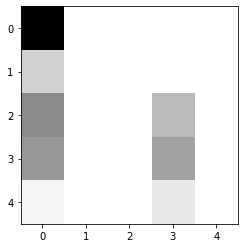

In [16]:
from sklearn.metrics import precision_score,accuracy_score
pred_y_=np.zeros((val_labels.shape))
for i in range(7):
  pred_y_[6*i:6*i+6]=model.predict(val_images[6*i:6*i+6])
cm=confusion_matrix(np.argmax(val_labels,axis=1),np.argmax(pred_y_,axis=1))
print(cm)
plt.imshow(cm, cmap='binary')
print(accuracy_score(np.argmax(val_labels,axis=1),np.argmax(pred_y_,axis=1))," accuracy")

In [17]:
del train_images,train_labels,val_images,val_labels

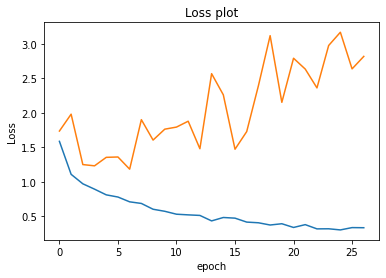

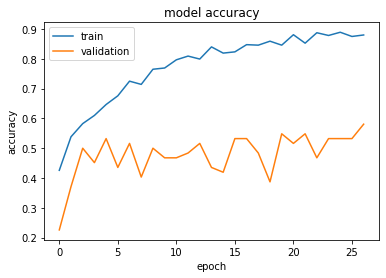

In [18]:
plt.plot(hist.history["loss"])
plt.plot(hist.history["val_loss"])
plt.title("Loss plot")
plt.ylabel("Loss")
plt.xlabel("epoch")
plt.show()

plt.plot(hist.history["accuracy"])
plt.plot(hist.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

[[34  0  0  0  0]
 [ 5  0  0  0  0]
 [15  0  0 17  0]
 [ 6  0  0 13  0]
 [ 3  0  1  8  1]]
0.46601941747572817  acuracy


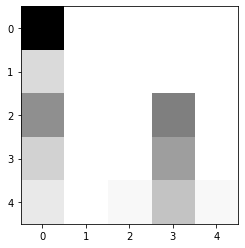

In [22]:
#preds = model.evaluate(test_images, test_labels)
#print("Loss = " + str(preds[0]))
#print("Test accuracy = " + str(preds[1]))
pred_y_=np.zeros((test_labels.shape))
for i in range(15):
  pred_y_[6*i:6*i+6]=model.predict(test_images[6*i:6*i+6])
cm=confusion_matrix(np.argmax(test_labels,axis=1),np.argmax(pred_y_,axis=1))
print(cm)
plt.imshow(cm, cmap='binary')
score=accuracy_score(np.argmax(test_labels,axis=1),np.argmax(pred_y_,axis=1))
print(score," acuracy")

## unfreeze and train

In [ ]:
count=0
model.trainable=True
for layer in model.layers:
  if layer.name[-2:]=='bn':
    layer.trainable=False
    count+=1
print(count," layers of bn freezed")
trainable_count = count_params(model.trainable_weights)
non_trainable_count = count_params(model.non_trainable_weights)

print('Total params: {:,}'.format(trainable_count + non_trainable_count))
print('Trainable params: {:,}'.format(trainable_count))
print('Non-trainable params: {:,}'.format(non_trainable_count))

In [23]:
random.seed = 2
tf.seed = 2
tf.random.set_seed(2)
opt = keras.optimizers.Adam(learning_rate = 1e-7, beta_1 = 0.9)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
early_stopping= tf.keras.callbacks.EarlyStopping(monitor = 'accuracy', min_delta = 0.01, patience = 5)
hist=model.fit(train_datagen.flow(train_images, train_labels,batch_size=4,shuffle=True),steps_per_epoch=len(train_images) / 4,
               epochs = 20,callbacks=[early_stopping]);

NameError: ignored

In [ ]:
#preds = model.evaluate(test_images, test_labels)
#print("Loss = " + str(preds[0]))
#print("Test accuracy = " + str(preds[1]))
pred_y_=np.zeros((test_labels.shape))
for i in range(11):
  pred_y_[10*i:10*i+10]=model.predict(test_images[10*i:10*i+10])
cm=confusion_matrix(np.argmax(test_labels,axis=1),np.argmax(pred_y_,axis=1))
print(cm)
plt.imshow(cm, cmap='binary')

NameError: ignored

In [ ]:
from sklearn.metrics import precision_score,accuracy_score
score=accuracy_score(np.argmax(test_labels,axis=1),np.argmax(pred_y_,axis=1))
print(score," acuracy")

In [ ]:
np.argmax(pred_y_,axis=1)

In [ ]:
np.argmax(test_labels,axis=1)

In [ ]:
def merge_seg_model_starting():
    IMG_SIZE=224
    NUM_CLASSES=5
    input_0=Input(shape=(IMG_SIZE, IMG_SIZE, 7),name="image input")
    output_0=Conv2D(filters=32,kernel_size=3,padding='same',activation='relu')(input_0)
    output_0=Conv2D(filters=3,kernel_size=3,padding='same',activation='relu')(output_0)
    
    model_0=Model(input_0,output_0)

    input_1 = Input(shape=(IMG_SIZE, IMG_SIZE, 3),name="image input")
    
    model = DenseNet121(include_top=False, input_tensor=input_1, weights="imagenet")
    # Freeze the pretrained weights
    model.trainable = False
    # Rebuild top

    x = Flatten(name="flatten")(model.output)
    
    top_dropout_rate = 0.2
    x = Dropout(top_dropout_rate, name="top_dropout_1")(x)
    x = Dense(256, activation="relu", name="last_dense_1")(x)
    x = Dropout(top_dropout_rate, name="top_dropout_2")(x)
    x = Dense(256, activation="relu", name="last_dense_2")(x)
    outputs = Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    model_1 = tf.keras.Model(input_1, outputs, name="DenseNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5,beta_1=0.9)
    
    model_fin=Sequential()
    model_fin.add(model_0)
    model_fin.add(model_1)
    
    model_fin.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    ) 
    return model_fin

In [ ]:
plt.plot(hist.history["accuracy"])
plt.plot(hist.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "validation"], loc="upper left")
plt.show()

In [ ]:
def merge_seg_model():
    IMG_SIZE=224
    NUM_CLASSES=5
    input_1 = Input(shape=(IMG_SIZE, IMG_SIZE, 3),name="image input")
    input_2 = Input(shape=(454,454,7),name="image+lesion input")

    lesion_features=Conv2D(kernel_size=3,filters=32)(input_2)
    lesion_features=layers.MaxPooling2D()(lesion_features)
    lesion_features=Conv2D(kernel_size=3,filters=64)(lesion_features)
    lesion_features=layers.MaxPooling2D()(lesion_features)
    
    model = DenseNet121(include_top=False, input_tensor=input_1, weights="imagenet")
    # Freeze the pretrained weights
    model.trainable = False

    output=layers.Concatenate()([model.layers[4].output,lesion_features])
    output=Conv2D(kernel_size=3,filters=64,padding='same')(output)
    
    #first part
    model_1=Model([input_1,input_2],[output])
    #model_1([input_1,input_2])
    model_1.summary()
    
    model_2=Model(output,model.output)
    """seq model don't work for concate layer"""
    #model_seq=Sequential(name='seq_model')
    #model_seq.add(model_1)
    #output=model_2(output)
    #for i in range(len(model.layers)-5):
      #output=model.layers[i+5](output)
      #model_seq.add(model.layers[i+5])
    
    # Rebuild top
    
    """top_dropout_rate = 0.2
    model_seq.add(Flatten(name='flatten'))
    model_seq.add(Dropout(top_dropout_rate, name="top_dropout_1"))
    model_seq.add(Dense(256, activation="relu", name="last_dense_1"))
    model_seq.add(Dropout(top_dropout_rate, name="top_dropout_2"))
    model_seq.add(Dense(256, activation="relu", name="last_dense_2"))
    model_seq.add(Dense(5, activation="softmax", name="pred"))
    """
    """
    # Rebuild top
    n bx = Flatten(name="flatten")(output)
    
    top_dropout_rate = 0.2
    x = Dropout(top_dropout_rate, name="top_dropout_1")(x)
    x = Dense(256, activation="relu", name="last_dense_1")(x)
    x = Dropout(top_dropout_rate, name="top_dropout_2")(x)
    x = Dense(256, activation="relu", name="last_dense_2")(x)
    outputs = Dense(NUM_CLASSES, activation="softmax", name="pred")(x)

    model_fin = tf.keras.Model([input_1,input_2], outputs, name="DenseNet")
    """
    #output=model_1([input_1,input_2])
    #output=model_seq(output)
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5,beta_1=0.9)
    model_seq.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model_seq


In [ ]:
model_=merge_seg_model()
model_.summary()

In [ ]:
model_merged_inp.summary()

In [ ]:
input_3=Input(shape=(None,112,112,64))
model_2=Model(input_3,model.output)

In [ ]:
class denseLayer(tf.keras.layers.Layer)
  def __init__(self, original_dim, intermediate_dim=64, name="decoder", **kwargs):
        super(denseLayer, self).__init__(name=name, **kwargs)
        self.dense_proj = layers.Dense(intermediate_dim, activation="relu")
        self.dense_output = layers.Dense(original_dim, activation="sigmoid")

    def call(self, inputs):
        x = self.dense_proj(inputs)
        return self.dense_output(x)

class myModel(tf.keras.Model):
